In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy
import os

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate, list_members
from utils.files import download_sheet, save, load
from utils.hash import digest
from utils.rounding import progressive_soft_round_loop

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess


In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_49": "1691041080",
}

if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_49 = download_sheet(rp_file_id, sheet_ids["data_10_49"])
    
    data = pd.concat([data_1_9, data_10_49], axis = 0)
    data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"], inplace=True)
    data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1}, inplace=True)
    data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''}, inplace=True)

    # data above 30 requires a 2nd ingredient to be valid.
    data.drop(  data.index[(data["Level"] >= 30) & (data["Amnt"] == 0.0)] , inplace=True )

    # data below 30 we clear 2nd ingredient
    data.loc[data["Level"] < 30, "Amnt"] = 0.0
    data.loc[data["Level"] < 30, "Ing2P"] = 0.0
    data.loc[data["Level"] < 30, "Ingredient 2"] = ""

    # data below 25 we clear 2nd skill, and below 10 we clear the 1st
    data.loc[data["Level"] < 25, "Sub Skill 2"] = ""
    data.loc[data["Level"] < 10, "Sub Skill 1"] = ""

    # avoid a bug in RP of freshly caught mon with skill up unlocked.
    # (We now trust the bugged data is quarantined so we can use the valid data)
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) )]
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) )]

    # only use data known to the Pokedex (we'll update Pokedex as needed)
    data.drop( data.index[~data["Pokemon"].isin( game.data.pokedex["Pokemon"]) ], inplace=True )
    
    data.to_pickle(fit_options.data_file)
    
else:
    
    data = pd.read_pickle(fit_options.data_file)


In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.000000,7374.0,7374.000000,7374.000000,7374.000000,7374.000000
mean,11.141307,632.758476,1.531462,632.758747,0.000271,3913.520477,3757.775542,12.330621,28.073637,38.339300,108.948603,1.034260,0.988131,0.994619,0.998996,1.007296,0.207215,34.649154,55.972878,148.355641,1.0,0.087063,3.595199,0.986615,1.030052
std,7.395758,413.364522,1.021417,413.356232,0.579500,973.736353,1036.938986,3.438557,2.618389,8.314001,16.187878,0.310627,0.058797,0.044959,0.117868,0.118611,0.044954,38.536982,28.103461,61.498021,0.0,0.557808,22.297651,0.039015,0.072430
min,1.000000,245.000000,1.000000,245.000000,-21.000000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.930000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,360.000000,1.000000,360.000000,0.000000,3100.000000,2911.230000,10.000000,26.000000,33.000000,98.000000,0.810000,1.000000,1.000000,1.000000,1.000000,0.180000,13.210000,36.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,488.000000,1.000000,488.000000,0.000000,3800.000000,3731.600000,12.000000,28.000000,37.000000,103.000000,0.960000,1.000000,1.000000,1.000000,1.000000,0.200000,20.200000,46.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,744.000000,2.000000,744.000000,0.000000,4500.000000,4419.000000,14.000000,31.000000,42.000000,115.000000,1.230000,1.000000,1.000000,1.000000,1.000000,0.230000,47.890000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3493.000000,6.000000,3495.000000,5.000000,6300.000000,6916.140000,23.000000,35.000000,83.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,414.090000,243.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.9,1.00,1.0,0.8,0.26,22.75,538.35,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.2,1.0,0.26,22.75,530.60,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arbok,9.0,582.0,Relaxed,1.0,,582.0,0.0,Relaxed,ArbokRelaxed91,Energy Recovery,EXP Gains,3700.0,3640.80,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.98,1.0,1.08,1.0,1.0,0.26,22.75,538.89,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arbok,9.0,489.0,Timid,1.0,,489.0,0.0,Timid,ArbokTimid91,EXP Gains,Speed of Help,3700.0,4004.88,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.89,1.1,1.00,1.0,1.0,0.26,22.75,538.45,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0


In [6]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())


In [7]:
# Compute per sample information about help time, nature, sub-skills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    7374.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Helps per hour, dtype: float64

In [8]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)

count    7374.00000
mean        0.20396
std         2.40053
min       -40.00000
25%        -1.00000
50%         0.00000
75%         2.00000
max        14.00000
Name: RP, dtype: float64

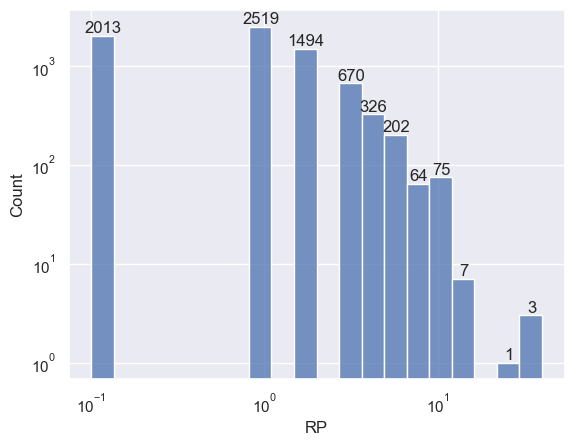

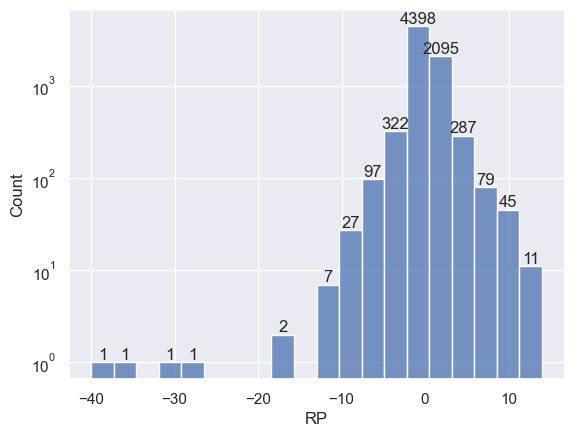

In [22]:
# what is the quality of the initial guess?

r= data["RP"] - np.round(RP(x0))
pd.Series(r).describe()

_ = plt.figure()
g = sns.histplot(x=np.clip(np.abs(r), 1e-1,1e3), log_scale=True, bins=20)
g.axes.set_yscale('log')
_ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r, bins=20)
_ = g.axes.set_yscale('log')
_ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

In [21]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = fit_options.result_file(digest(data, x0))

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")

else:

    opt = progressive_soft_round_loop( x0,
            lambda x: scipy.optimize.least_squares(residual, x, **fit_options.least_squares_kwargs)
         )

    # save results and remove some stuff we don't need to save.
    if 'jac' in opt: del opt.jac
    if 'active_mask' in opt: del opt.active_mask
    if 'fun' in opt: del opt.fun
    if 'final_simplex' in opt: del opt.final_simplex

    save(filename, opt)

Loaded from cache


In [11]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.564e-01  2.544e-01 ...  2.216e-01  2.211e-01]
       cost: 1158.7011522265375
       grad: [ 4.339e-06  3.188e-05 ...  0.000e+00  0.000e+00]
 optimality: 0.011293875752016902
       nfev: 46
       njev: 27

count    7374.000000
mean       -0.002034
std         0.552293
min        -5.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        15.000000
Name: RP, dtype: float64

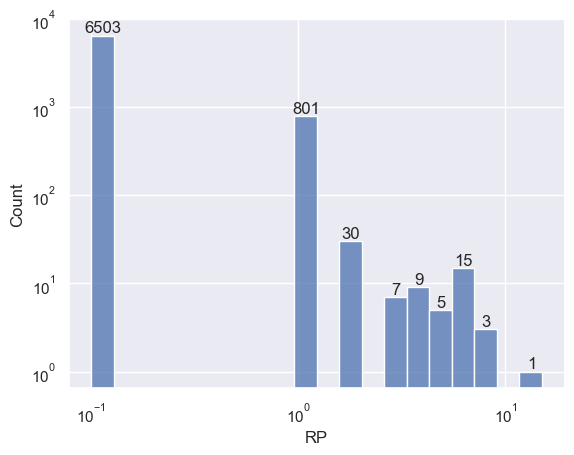

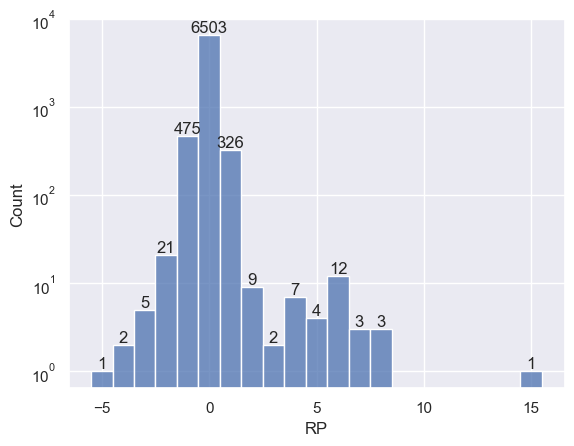

In [17]:
r_opt = data["RP"] - np.round(RP(opt.x))
pd.Series(r_opt).describe()

_ = plt.figure()
g = sns.histplot(x=np.clip(np.abs(r_opt), 1e-1,1e3), log_scale=True, bins=20)
g.axes.set_yscale('log')
_ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r_opt, discrete=1)
_ = g.axes.set_yscale('log')
_ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])


In [13]:
sol = unpack(opt.x, unpack_info)
table(sol)

Pokemons ing fractions,[0.25635681 0.25442552 0.2655396 ... 0.18028174 0.20048438 0.21578449]
Pokemons skill products,[16.70527395 16.71166754 18.48069215 ... 44.6850873 12.80024731 15.52163755]
Charge Strength S,[0.74637674 0.32256649]
Charge Strength M,[0.74537135 0.32266668]
Ingredient Magnet S,[0.74565748 0.32256325]
Cooking Power-Up S,[0.74459009 0.3231066 ]
Extra Helpful S,[0.74589667 0.32236571]
Charge Energy S,[0.74829536 0.32199671]
Energizing Cheer S,[0.74664101 0.32196701]
Energy for Everyone S,[0.74568827 0.32280171]
Dream Shard Magnet S,[0.74538854 0.32238899]


In [14]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.data.pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.635681,16.705274
Ivysaur,25.442552,16.711668
Venusaur,26.553960,18.480692
Charmander,20.044682,9.673786
Charmeleon,22.673072,14.049777
Charizard,22.341940,14.127225
Squirtle,27.020366,17.600707
Wartortle,27.040211,17.591378
Blastoise,27.425108,18.467230


In [15]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.data.mainskills.to_dict(orient='records') :
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.422774,1.421142,1.421393,1.420902,1.421288,1.424806,1.421572,1.422130,1.420386,1.422424
3,1.964376,1.962320,1.962464,1.962852,1.961931,1.966062,1.961541,1.963950,1.960731,1.964250
4,2.712149,2.709581,2.709500,2.711508,2.708228,2.712930,2.706611,2.712198,2.706635,2.712468
5,3.744573,3.741403,3.740904,3.745711,3.738410,3.743519,3.734688,3.745522,3.736298,3.745695
6,5.170007,5.166148,5.164925,5.174373,5.160462,5.165608,5.153269,5.172534,5.157667,5.172496


In [16]:
# What are the worst points?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = data["RP"] - np.round(RP(opt.x))
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False).reset_index(drop=True)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
0,Glaceon,GlaceonNeutral276Skill Level Up MHelping Speed M,27.0,6.0,-,-,Skill Level Up M,Helping Speed M,2485.0,2469.619472,15.0,225.0
1,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1520.227377,8.0,64.0
2,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1273.548783,8.0,64.0
3,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1432.144671,8.0,64.0
4,Sylveon,SylveonRelaxed102Helping bonus,10.0,2.0,Energy Recovery,EXP Gains,Helping bonus,,1023.0,1015.696145,7.0,49.0
5,Charizard,CharizardNeutral273Inventory Up MHelping Speed M,27.0,3.0,-,-,Inventory Up M,Helping Speed M,1299.0,1292.295812,7.0,49.0
6,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1754.186137,7.0,49.0
7,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1507.500548,6.0,36.0
8,Butterfree,ButterfreeNeutral103Sleep EXP Bonus,10.0,3.0,-,-,Sleep EXP Bonus,,843.0,837.152258,6.0,36.0
9,Butterfree,ButterfreeImpish105Skill Level Up M,10.0,5.0,Energy Recovery,Ingredient Finding,Skill Level Up M,,901.0,894.723434,6.0,36.0
